<a href="https://colab.research.google.com/github/gibi177/NOIA/blob/main/Rede%20Convolucional%20e%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Convolucional e Transfer Learning

### Trabalho 2 da disciplina Noções de Inteligência Artificial - 2/2024
### Alunos: Felipe Lopes Gibin Duarte e Matheus das Neves Fernandes

## Introdução
Neste trabalho usaremos uma rede convolucional pré-treinada (VGG) e a aplicaremos em um problema novo. Experimentaremos com a divisão da base em treinamento, validação e teste, e usaremos validação para o "early stopping" na tentativa de controlar o sobre-ajuste. A base de dados usada é a "TensorFlow Flowers Dataset". Ela contém 3670 imagens coloridas de flores pertencentes a uma de 5 classes: Margarida,
Dente-de-leão, Rosa, Girassol e Tulipa.

## 1. Preparação do Ambiente
Nesta seção, importaremos as bibliotecas necessárias e carregaremos a base de dados.

### 1.1 Importação de bibliotecas

In [52]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns

## 1.2 Carregamento dos dados

In [53]:
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
"tf_flowers",
split=["train[:70%]", "train[70%:]"], ## Train test split
batch_size=-1,
as_supervised=True, # Include labels
)

## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

print (train_ds.shape)
print (test_ds.shape)

(2569, 150, 150, 3)
(1101, 150, 150, 3)


## 2. Treinando um MLP
Vamos comprovar que um MLP não apresenta desempenho satisfatório para o problema. Vamos evitar o overfitting ao usar a técnica de parada prematura de treinamento (early stopping), após 5 épocas sem melhora no parâmetro monitorado (neste caso a precisão de treinamento, val_accuracy), o treinamento é interrompido. Observamos que o MLP apresenta uma acurácia de cerca de 30%. Conforme esperado ele não resolve bem o problema de classificação.

In [54]:
model_MLP = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dense(256, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dense(5, activation='softmax')  #Camada de saída
])

model_MLP.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

model_MLP.fit(
    train_ds,
    train_labels,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]
)

# Evaluate the model on the test dataset
loss, accuracy = model_MLP.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.2315 - loss: 933.9344 - val_accuracy: 0.3191 - val_loss: 200.2218
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3680 - loss: 141.5890 - val_accuracy: 0.3482 - val_loss: 58.6519
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4110 - loss: 39.0412 - val_accuracy: 0.3521 - val_loss: 38.7272
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4322 - loss: 29.1203 - val_accuracy: 0.3794 - val_loss: 31.6875
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4261 - loss: 23.5515 - val_accuracy: 0.3424 - val_loss: 25.9883
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4406 - loss: 17.1785 - val_accuracy: 0.3677 - val_loss: 21.4287
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4534 - loss: 11.1555 - val_accuracy: 0.3949 - val_loss: 14.7411
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4720 - loss: 10.0517 - val_a

### 2.1 Testando técnicas de normalização
Vamos explorar técnicas como normalização L1,L2 e dropout, avaliando seu impacto no desempenho

In [55]:
# Regularização L1

model_MLP = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.01)),   #Camada escondida 1
    tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l1(0.01)),   #Camada escondida 2
    tf.keras.layers.Dense(5, activation='softmax')  #Camada de saída
])

model_MLP.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

model_MLP.fit(
    train_ds,
    train_labels,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]

)

# Evaluate the model on the test dataset
loss, accuracy = model_MLP.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.2438 - loss: 1290.8032 - val_accuracy: 0.2782 - val_loss: 525.0865
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3361 - loss: 382.5100 - val_accuracy: 0.3599 - val_loss: 254.4893
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3846 - loss: 231.7951 - val_accuracy: 0.3949 - val_loss: 189.5384
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4192 - loss: 179.4470 - val_accuracy: 0.2957 - val_loss: 169.5493
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3335 - loss: 178.9991 - val_accuracy: 0.3405 - val_loss: 159.5130
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3256 - loss: 167.4659 - val_accuracy: 0.2646 - val_loss: 152.6748
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2683 - loss: 150.9249 - val_accuracy: 0.2082 - val_loss: 202.6531
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2335 - loss: 147.

In [56]:
# Regularização L2

model_MLP = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),   #Camada escondida 1
    tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)),   #Camada escondida 2
    tf.keras.layers.Dense(5, activation='softmax')  #Camada de saída
])

model_MLP.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

model_MLP.fit(
    train_ds,
    train_labels,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]

)

# Evaluate the model on the test dataset
loss, accuracy = model_MLP.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.2488 - loss: 740.9683 - val_accuracy: 0.2743 - val_loss: 217.9027
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3558 - loss: 166.5440 - val_accuracy: 0.3755 - val_loss: 89.9414
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4118 - loss: 79.8818 - val_accuracy: 0.3521 - val_loss: 70.7541
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4396 - loss: 61.0481 - val_accuracy: 0.3716 - val_loss: 52.8450
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4290 - loss: 36.0388 - val_accuracy: 0.3988 - val_loss: 27.1568
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4692 - loss: 18.1743 - val_accuracy: 0.3444 - val_loss: 30.7458
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4428 - loss: 19.1244 - val_accuracy: 0.2860 - val_loss: 15.9914
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3728 - loss: 13.5681 - val_ac

In [57]:
# Dropout

model_MLP = tf.keras.Sequential([
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(5, activation='softmax')  #Camada de saída
])

model_MLP.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

model_MLP.fit(
    train_ds,
    train_labels,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]

)

# Evaluate the model on the test dataset
loss, accuracy = model_MLP.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.2136 - loss: 723.9809 - val_accuracy: 0.2568 - val_loss: 2.0243
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2476 - loss: 2.4093 - val_accuracy: 0.2529 - val_loss: 1.6382
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2561 - loss: 1.7675 - val_accuracy: 0.2529 - val_loss: 1.5973
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2499 - loss: 1.6554 - val_accuracy: 0.2529 - val_loss: 1.5954
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2662 - loss: 1.6256 - val_accuracy: 0.2529 - val_loss: 1.5958
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2563 - loss: 1.6077 - val_accuracy: 0.2529 - val_loss: 1.5966
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2394 - loss: 10.6997
Accuracy: 0.22979110479354858


## 3. Uso da rede VGG16 pré treinada
Vamos utilizar a rede VGG16 como pré processamento fixo das imagens. Ainda que essa rede tenha sido treinada em um conjunto de dados muito mais amplo do que somente flores, vamos verificar que podemos reusar esse treinamento para aumentar a performance do nosso problema de classificação.

### 3.1 Processamento da rede VGG
Carregamos o modelo VGG, pre processamos os dados e checamos se o formato deles está em tensores condizentes com o MLP

In [58]:
# Carregando modelo VGG16
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

# Dados são processados de maneira semelhante ao treinamento original da VGG16.
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

# Checando se o formato dos dados esta consistente com o MLP
print(train_ds.shape)
print(test_ds.shape)

# Resumo da arquitetura do modelo
base_model.summary()

(2569, 150, 150, 3)
(1101, 150, 150, 3)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### 3.2 Treinamento do MLP que sucede a VGG
Adicionamos dropout e regularização L1+L2 (elastic net) afim de evitar overfitting do modelo

In [59]:
model_MLP_from_VGG = tf.keras.Sequential([
    base_model,                                     #Base do VGG
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),

    tf.keras.layers.Dense(5, activation='softmax')  #Camada de saída
])

model_MLP_from_VGG.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #Entropia cruzada
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

model_MLP_from_VGG.fit(
    train_ds,
    train_labels,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]

)

# Evaluate the model on the test dataset
loss, accuracy = model_MLP_from_VGG.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.3211 - loss: 6.9149 - val_accuracy: 0.5078 - val_loss: 3.9658
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5188 - loss: 3.8592 - val_accuracy: 0.6012 - val_loss: 3.3770
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6235 - loss: 3.1760 - val_accuracy: 0.6420 - val_loss: 2.8397
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.6466 - loss: 2.7088 - val_accuracy: 0.6673 - val_loss: 2.4927
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.6863 - loss: 2.2517 - val_accuracy: 0.6848 - val_loss: 2.1519
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.7336 - loss: 1.9240 - val_accuracy: 0.6693 - val_loss: 2.0169
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.7291 - loss: 1.6875 - val_accuracy: 0.7082 - val_loss: 1.7684
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.7536 - loss: 1.4318 - val_accuracy: 0.723

## 4. Erros de classificação e Matriz de confusão
Nesta seção iremos visualizar erros de classificação e a respectiva matriz de confusão do MLP sucedido da VGG com regularizações l1, l2 e dropout.

## 4.1 Erros de Classificação

Definição da função plot_misclassified_images que testa o MLP treinado para dados de validação e pega as imagens mal classificadas

In [64]:
# Cria um dicionário para traduzir os números das classes (0, 1, 2...)
# para os nomes das flores ('Margarida', 'Dente-de-leão'...).
flower_names = {
    0: 'Margarida',
    1: 'Dente-de-leão',
    2: 'Rosa',
    3: 'Girassol',
    4: 'Tulipa'
}


def plot_misclassified_images(model, test_ds, test_labels, num_images=5):
    predictions = model.predict(test_ds) # Pede ao modelo para prever as classes das imagens de teste.
    predicted_labels = np.argmax(predictions, axis=1) # Extrai a classe que o modelo previu para cada imagem.
    misclassified_indices = np.where(predicted_labels != test_labels)[0] # Encontra as imagens que o modelo errou.

    # Se o modelo não errou nenhuma, avisa e para por aqui.
    if len(misclassified_indices) == 0:
        print("No misclassified images found.")
        return

    # Limita o número de imagens a serem mostradas.
    num_images = min(num_images, len(misclassified_indices))

    # Calcula quantas linhas e colunas o gráfico terá (máximo 4 colunas).
    num_cols = min(num_images, 4)
    num_rows = (num_images + num_cols - 1) // num_cols

    # Cria o gráfico com os subplots para mostrar as imagens.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Para cada imagem errada:
    for i in range(num_images):
        index = misclassified_indices[i] # Pega o índice da imagem.
        image = test_ds[index] # Pega a imagem.
        true_label = test_labels[index] # Pega a classe real da imagem.
        predicted_label = predicted_labels[index] # Pega a classe que o modelo previu.

        # Ajusta a imagem para ser exibida corretamente.
        image = image.numpy()
        image = np.clip(image, 0, 255)
        image = image.astype(np.uint8)

        # Traduz os números das classes para os nomes das flores.
        true_flower_name = flower_names[true_label.numpy().astype(int)]
        predicted_flower_name = flower_names[predicted_label]

        # Calcula a posição da imagem no gráfico.
        row = i // num_cols
        col = i % num_cols

        # Mostra a imagem no gráfico.
        axes[row, col].imshow(image)

        # Cria um título para a imagem, mostrando a classe real e a prevista.
        bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
        title = f"Real: {true_flower_name}, Pred: {predicted_flower_name}"
        axes[row, col].text(0.5, 1.05, title, ha="center", va="bottom", transform=axes[row, col].transAxes, bbox=bbox_props)

        # Remove os eixos da imagem.
        axes[row, col].axis('off')

    # Esconde os subplots vazios, se houver.
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

    # Ajusta o layout do gráfico e o exibe.
    plt.tight_layout()
    plt.show()

Executa a função de plotar imagens mal classificadas, passando o numero de imagens igual a 10. No caso, plota imagens mal classificadas do MLP precedido da rede VGG.

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


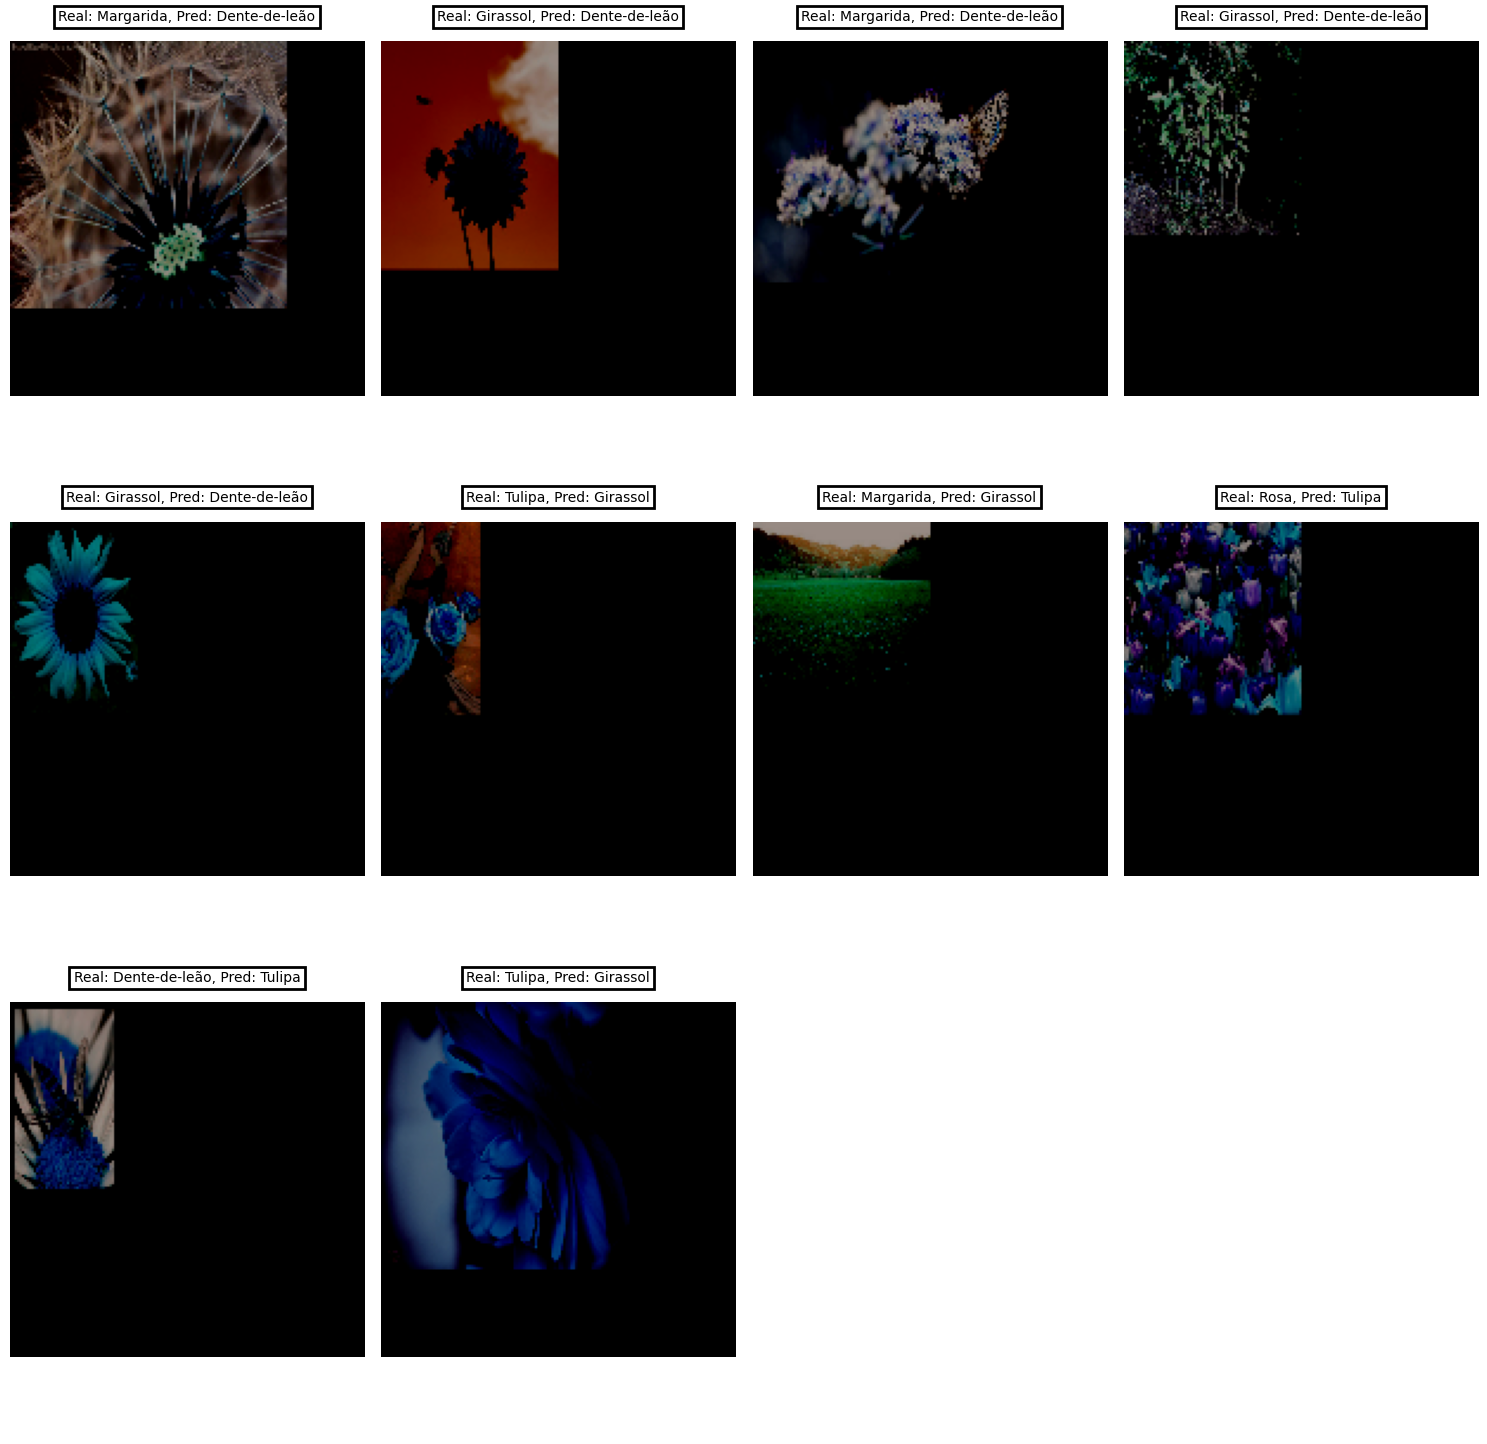

In [65]:
plot_misclassified_images(model_MLP_from_VGG, test_ds, test_labels, 10)

## 4.2 Matriz de Confusão

Definição da função que plota a matriz de confusão do MLP através dos dados de validação.

In [62]:
def plot_confusion_matrix(model, test_ds, test_labels, flower_names):
    # Obtém as previsões do modelo para o conjunto de dados de teste
    predictions = model.predict(test_ds)
    # Extrai a classe prevista (com maior probabilidade) para cada imagem
    predicted_labels = np.argmax(predictions, axis=1)

    # Calcula a matriz de confusão
    cm = confusion_matrix(test_labels, predicted_labels)

    # Plota a matriz de confusão usando seaborn (para melhor visualização)
    plt.figure(figsize=(10, 8)) # Define o tamanho da figura
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=flower_names.values(),
                yticklabels=flower_names.values())
    plt.title("Matriz de Confusão") # Define o título do gráfico
    plt.ylabel("Classe Real") # Define o rótulo do eixo y
    plt.xlabel("Classe Prevista") # Define o rótulo do eixo x
    plt.show() # Exibe o gráfico

Executa a função que plota a matriz de confusão de um MPL com o MLP precedido da rede VGG.

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


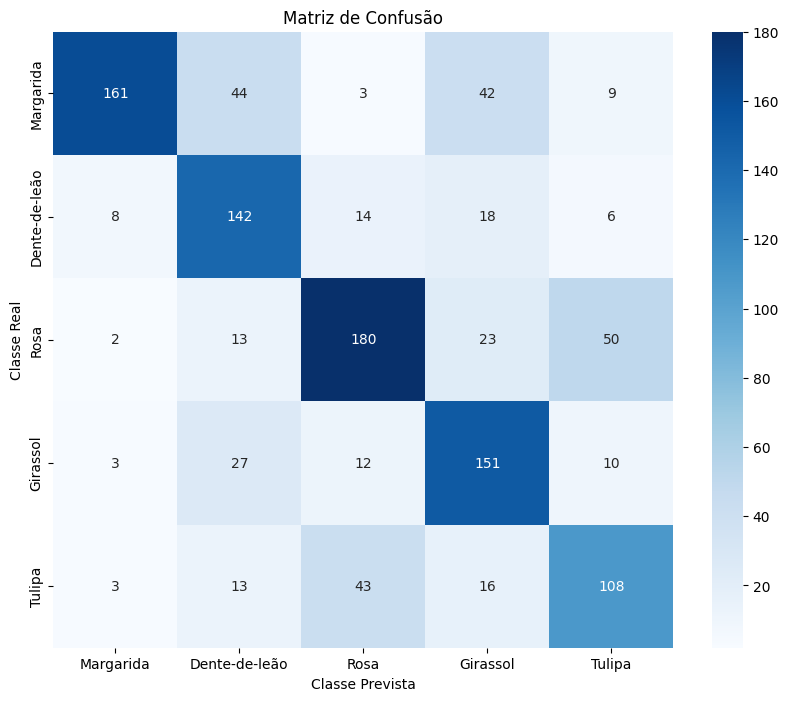

In [63]:
plot_confusion_matrix(model_MLP_from_VGG, test_ds, test_labels, flower_names)